In [ ]:
import torch        #pytorch 사용하기 위함
import torchvision  #데이터 셋, 아키텍처 모델, 이미지 변환 기능으로 구성된 패키지
import torchvision.transforms as transforms  #다양한 이미지 변환기능 제공, 데이터 불러오면서 바로 전처리 가능

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Download CIFAR-10 dataset

In [ ]:
#Compose() 안의 순서대로 전처리 작업 수행
#transforms.ToTensor(): 데이터 타입을 Tensor 형태로 변경, 이미지(0~255) -> 0~1 사이 값으로 바뀜
#파이토치를 사용해 프로세스 진행하려면 이미지를 텐서로 변환해야함
transform = transforms.Compose([transforms.ToTensor()]) 

batch_size = 4  #배치 사이즈

#dataset 불러오기
#root: 경로 지정, train=True: train 데이터 받아옴
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#DataLoder: 배치 사이즈 형태로 만들어서 실제로 학습시 이용가능한 형태로 만듦
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


In [ ]:
# Statistics of the dataset

print('Number of train set: {}'.format(len(trainset)))
print('Number of test set: {}'.format(len(testset)))
print('Size of each image[batch, channel, width, height]: {}'.format(images.shape))
print('Number of class per each classes: {}'.format(len(trainset.classes)))
print('Number of images per each classes: {}'.format(len(images)))

Number of train set: 50000
Number of test set: 10000
Size of each image[batch, channel, width, height]: torch.Size([4, 3, 32, 32])
Number of class per each classes: 10
Number of images per each classes: 4


In [ ]:
#Number of images per each classes 구하기

class_count = {}
for _, index in trainset:
    label = trainset.classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

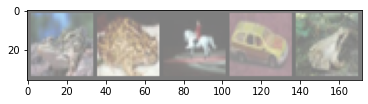

In [ ]:
# Show random 5 images from each classes

batch_size_five = 5
trainloader_five = torch.utils.data.DataLoader(trainset, batch_size=batch_size_five,
                                          shuffle=True, num_workers=2)

# get some random training images
dataiter_five = iter(trainloader_five)
images_five, labels_five = dataiter_five.next()

# show images
imshow(torchvision.utils.make_grid(images_five))

In [ ]:
#Report the mean and standard deviation of the training datasets for each color channels (R,G,B)

R_channel, G_channel, B_channel = [], [], []

for i in range(len(trainset)):
  R_channel.append(trainset[i][0][0].reshape(1,-1).numpy())
  G_channel.append(trainset[i][0][1].reshape(1,-1).numpy())
  B_channel.append(trainset[i][0][2].reshape(1,-1).numpy())
  i = i + 1

print('Mean of R channel: {}, Standard deviation of R channel: {}'.format(np.mean(R_channel), np.std(R_channel)))
print('Mean of G channel: {}, Standard deviation of G channel: {}'.format(np.mean(G_channel), np.std(G_channel)))
print('Mean of B channel: {}, Standard deviation of B channel: {}'.format(np.mean(B_channel), np.std(B_channel)))

mean_total = [np.mean(R_channel), np.mean(G_channel), np.mean(B_channel)]
std_total = [np.std(R_channel), np.std(G_channel), np.std(B_channel)]


Mean of R channel: 0.4913996756076813, Standard deviation of R channel: 0.24703232944011688
Mean of G channel: 0.48215827345848083, Standard deviation of G channel: 0.24348504841327667
Mean of B channel: 0.4465312361717224, Standard deviation of B channel: 0.2615876793861389


#Design a CNN architecture

In [ ]:
#Hyperparameters

Learning_rate = 0.001
Momentum = 0.9
batch_size = 4
epochs = 5 #number of training epoch

In [ ]:
#Design a CNN architecture

class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = CNN_Net()

criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(model.parameters(), lr=Learning_rate, momentum=Momentum)  #lr=0.001, momentum=0.9

In [ ]:
#Train the Network

train_loss_arr=[]
test_accuracy_arr = []

for epoch in range(1, epochs+1):  #데이터셋 5번 받기
    
    # 모델 학습 과정
    train_loss = 0.0
    model.train()
    for data, target in trainloader:

        #학습
        optimizer.zero_grad()  
        output = model(data) #forward pass
        loss = criterion(output, target) #batch loss 계산
        loss.backward() #backward pass
        optimizer.step() #parameter update
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.dataset)
    train_loss_arr.append(train_loss)

    print('Epoch:{} \tTraining Loss: {: .6f}'.format(epoch, train_loss))
    
    # 모델 테스트 과정
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    for data, target in testloader:
      output = model(data) #forward pass
      loss = criterion(output, target)  #batch loss 계산
      test_loss += loss.item()*data.size(0)  #test loss update
      _, pred = torch.max(output, 1)  #predicted class로 output 확률 전환
      correct_tensor = pred.eq(target.data.view_as(pred)) # true label과 prediction 비교
      correct = np.squeeze(correct_tensor.numpy())  #Tensor를 numpy 배열로 변환하고 길이가 1인 축을 제거

      for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    test_accuracy_arr.append(np.sum(class_correct) / np.sum(class_total))

    print('\nTest Accuracy (Overall): {}%'.format(100. * np.sum(class_correct) / np.sum(class_total)))

print('Finished Training')


Epoch:1 	Training Loss:  1.971934

Test Accuracy (Overall): 40.14%
Epoch:2 	Training Loss:  1.512455

Test Accuracy (Overall): 48.08%
Epoch:3 	Training Loss:  1.394752

Test Accuracy (Overall): 50.93%
Epoch:4 	Training Loss:  1.313706

Test Accuracy (Overall): 52.66%
Epoch:5 	Training Loss:  1.244078

Test Accuracy (Overall): 56.1%
Finished Training


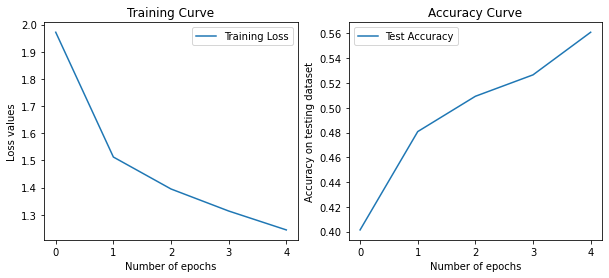

Final Test Accuracy : 56.10%
Final Loss : 1.24


In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(train_loss_arr, label = 'Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss values')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Curve')
plt.plot(test_accuracy_arr, label = 'Test Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on testing dataset')
plt.legend()
plt.show()

print('Final Test Accuracy : {:.2f}%'.format(test_accuracy_arr[-1]*100))
print('Final Loss : {:.2f}'.format(train_loss_arr[-1]))

#Normalize the inputs with mean and standard deviation

In [ ]:
#Normalize the inputs with mean and standard deviation
#1-(a)에서 구한 mean_total, std_total 이용

transform_Norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_total, std=std_total)  #Normalize: 1-(a)에서 구한 훈련 데이터의 평균, 표준편차를 이용
])

trainset_Norm = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_Norm) 

trainloader_Norm = torch.utils.data.DataLoader(trainset_Norm, batch_size=batch_size,shuffle=True, num_workers=2)

testset_Norm = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_Norm)

testloader_Norm = torch.utils.data.DataLoader(testset_Norm, batch_size=batch_size,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model_Norm = CNN_Net() #1-(b)의 CNN network 구조 사용

criterion_Norm = nn.CrossEntropyLoss()  #loss function
optimizer_Norm = optim.SGD(model_Norm.parameters(), lr=Learning_rate, momentum=Momentum)  #lr=0.001, momentum=0.9

In [ ]:
train_loss_arr_Norm=[]
test_accuracy_arr_Norm = []

for epoch in range(1, epochs+1):  #데이터셋 5번 받기
    
    #모델 학습 과정
    train_loss = 0.0
    model_Norm.train()
    for data, target in trainloader_Norm:

        optimizer_Norm.zero_grad()  
        output = model_Norm(data) #forward pass
        loss = criterion_Norm(output, target) #batch loss 계산
        loss.backward() #backward pass
        optimizer_Norm.step() #parameter update
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader_Norm.dataset)
    train_loss_arr_Norm.append(train_loss)

    print('Epoch:{} \tTraining Loss: {: .6f}'.format(epoch, train_loss))

    #모델 테스트
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data, target in testloader_Norm:
      output = model_Norm(data) #forward pass
      loss = criterion_Norm(output, target)  #batch loss 계산
      test_loss += loss.item()*data.size(0)  #test loss update
      _, pred = torch.max(output, 1)  #predicted class로 output 확률 전환
      correct_tensor = pred.eq(target.data.view_as(pred)) # true label과 prediction 비교
      correct = np.squeeze(correct_tensor.numpy())  #Tensor를 numpy 배열로 변환하고 길이가 1인 축을 제거

      for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    test_accuracy_arr_Norm.append(np.sum(class_correct) / np.sum(class_total))

    print('\nTest Accuracy (Overall): {}%'.format(100. * np.sum(class_correct) / np.sum(class_total)))


print('Finished Training')


Epoch:1 	Training Loss:  1.643360

Test Accuracy (Overall): 50.98%
Epoch:2 	Training Loss:  1.307033

Test Accuracy (Overall): 54.01%
Epoch:3 	Training Loss:  1.190007

Test Accuracy (Overall): 57.44%
Epoch:4 	Training Loss:  1.112598

Test Accuracy (Overall): 59.66%
Epoch:5 	Training Loss:  1.054215

Test Accuracy (Overall): 61.55%
Finished Training


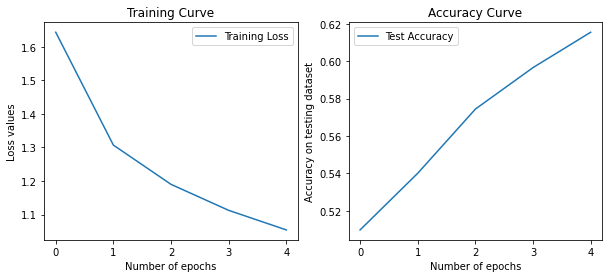

Final Test Accuracy : 61.55%
Final Loss : 1.05


In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(train_loss_arr_Norm, label = 'Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss values')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Curve')
plt.plot(test_accuracy_arr_Norm, label = 'Test Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on testing dataset')
plt.legend()
plt.show()

print('Final Test Accuracy : {:.2f}%'.format(test_accuracy_arr_Norm[-1]*100.))
print('Final Loss : {:.2f}'.format(train_loss_arr_Norm[-1]))

#MLP와 비교

In [ ]:
# MLP network에 적용하기 위해 CIFAR10 데이터 다시 불러오기
import torchvision.datasets as datasets

def cifar_loaders(batch_size, shuffle_test=False): 

    train = datasets.CIFAR10('./', train=True, download=True, 
        transform=transforms.Compose([transforms.ToTensor()]))
    test = datasets.CIFAR10('./', train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    
    trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    
    return trainloader, testloader

batch_size = 4

trainloader_MLP, testloader_MLP = cifar_loaders(batch_size)

Files already downloaded and verified


In [ ]:
class MLP_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(32*32*3, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, 128)
    self.layer4 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, img):
    flattened = img.reshape(-1, 32*32*3)
    out = self.layer1(flattened)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.relu(out)
    out = self.layer3(out)
    out = self.relu(out)
    out = self.layer4(out)
    return F.log_softmax(out)

In [ ]:
model_MLP = MLP_Net()

criterion_MLP = nn.CrossEntropyLoss()  #loss function
optimizer_MLP = optim.SGD(model_MLP.parameters(), lr=Learning_rate, momentum=Momentum)  #lr=0.001, momentum=0.9

In [ ]:
train_loss_arr_MLP=[]
test_accuracy_arr_MLP = []

for epoch in range(1, epochs+1):  #데이터셋 5번 받기
    
    #모델 학습 과정
    train_loss = 0.0
    total_batches = 0

    model_MLP.train()
    for i, (images, labels) in enumerate(trainloader_MLP):

        #학습
        optimizer_MLP.zero_grad()  

        output = model_MLP(images) #forward pass
        loss = criterion_MLP(output, labels) #batch loss 계산
        loss.backward() #backward pass
        optimizer_MLP.step() #parameter update

        train_loss += loss.item()
        total_batches += 1
        
    train_loss = train_loss/total_batches
    train_loss_arr_MLP.append(train_loss)

    print('Epoch:{} \tTraining Loss: {: .6f}'.format(epoch, train_loss))

    #모델 테스트
    correct = 0
    total = 0
    for images, labels in testloader_MLP:

        outputs_test = model_MLP(images)
        _, predicted = torch.max(outputs_test.data, 1)

        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        
    test_accuracy_arr_MLP.append(correct / total) 
            
    print('Accuracy on test images: %d %%' % (100 * correct / total))


print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:1 	Training Loss:  1.895063
Accuracy on test images: 35 %
Epoch:2 	Training Loss:  1.693950
Accuracy on test images: 41 %
Epoch:3 	Training Loss:  1.608639
Accuracy on test images: 43 %
Epoch:4 	Training Loss:  1.549923
Accuracy on test images: 46 %
Epoch:5 	Training Loss:  1.504292
Accuracy on test images: 47 %
Finished Training


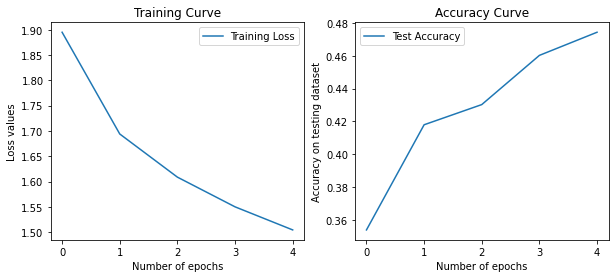

Final Test Accuracy : 47.43%
Final Loss : 1.50


In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(train_loss_arr_MLP, label = 'Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss values')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Curve')
plt.plot(test_accuracy_arr_MLP, label = 'Test Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on testing dataset')
plt.legend()
plt.show()

print('Final Test Accuracy : {:.2f}%'.format(test_accuracy_arr_MLP[-1]*100.))
print('Final Loss : {:.2f}'.format(train_loss_arr_MLP[-1]))


#Train with Adam optimizer

In [ ]:
#Adam Optimizer

model_Adam = CNN_Net()
criterion_Adam = nn.CrossEntropyLoss()  #loss function
optimizer_Adam = optim.Adam(model_Adam.parameters(), lr=Learning_rate)  

In [ ]:
train_loss_arr_Adam=[]
test_accuracy_arr_Adam = []

for epoch in range(1, epochs+1):  #데이터셋 5번 받기
    
    #모델 학습 과정
    train_loss = 0.0
    model_Adam.train()
    for data, target in trainloader:  

        #학습
        optimizer_Adam.zero_grad()  
        output = model_Adam(data) #forward pass
        loss = criterion_Adam(output, target) #batch loss 계산
        loss.backward() #backward pass
        optimizer_Adam.step() #parameter update
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.dataset)
    train_loss_arr_Adam.append(train_loss)

    print('Epoch:{} \tTraining Loss: {: .6f}'.format(epoch, train_loss))

    #모델 테스트 
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model_Adam.eval()
    for data, target in testloader:
      output = model_Adam(data) #forward pass
      loss = criterion_Adam(output, target)  #batch loss 계산
      test_loss += loss.item()*data.size(0)  #test loss update
      _, pred = torch.max(output, 1)  #predicted class로 output 확률 전환
      correct_tensor = pred.eq(target.data.view_as(pred)) # true label과 prediction 비교
      correct = np.squeeze(correct_tensor.numpy())  #Tensor를 numpy 배열로 변환하고 길이가 1인 축을 제거

      for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    test_accuracy_arr_Adam.append(np.sum(class_correct) / np.sum(class_total))

    print('\nTest Accuracy (Overall): {}%'.format(100. * np.sum(class_correct) / np.sum(class_total)))

print('Finished Training')

Epoch:1 	Training Loss:  1.676494

Test Accuracy (Overall): 42.38%
Epoch:2 	Training Loss:  1.452424

Test Accuracy (Overall): 49.66%
Epoch:3 	Training Loss:  1.355273

Test Accuracy (Overall): 51.43%
Epoch:4 	Training Loss:  1.289885

Test Accuracy (Overall): 52.59%
Epoch:5 	Training Loss:  1.237635

Test Accuracy (Overall): 53.59%
Finished Training


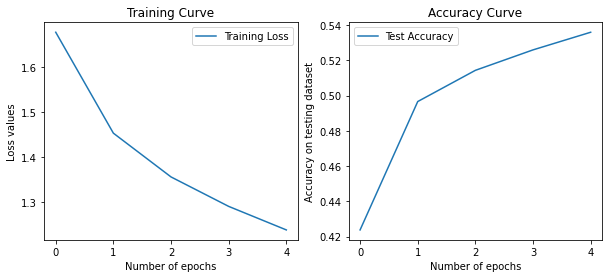

Final Test Accuracy : 53.59%
Final Loss : 1.24


In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(train_loss_arr_Adam, label = 'Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss values')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Curve')
plt.plot(test_accuracy_arr_Adam, label = 'Test Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on testing dataset')
plt.legend()
plt.show()

print('Final Test Accuracy : {:.2f}%'.format(test_accuracy_arr_Adam[-1]*100.))
print('Final Loss : {:.2f}'.format(train_loss_arr_Adam[-1]))

#Change the hyperparameters and network architectures

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 50
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
                                
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader_f = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader_f = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_f = ResNet(ResidualBlock, [2, 2, 2]).to(device)

Files already downloaded and verified


In [ ]:
batch_size = 4

# Loss and optimizer
criterion_f = nn.CrossEntropyLoss()
optimizer_f = torch.optim.Adam(model_f.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

train_loss_arr_f=[]
test_accuracy_arr_f = []

for epoch in range(1, num_epochs+1):  
    
    #모델 학습 과정
    train_loss = 0.0
    model_f.train()
    for data, target in train_loader_f:

        optimizer_f.zero_grad()  
        output = model_f(data) #forward pass
        loss = criterion_f(output, target) #batch loss 계산
        loss.backward() #backward pass
        optimizer_f.step() #parameter update
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader_f.dataset)
    train_loss_arr_f.append(train_loss)
 
    print('Epoch:{} \tTraining Loss: {: .6f}'.format(epoch, train_loss))

    #모델 테스트
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model_f.eval()
    for data, target in test_loader_f:
      output = model_f(data) #forward pass
      loss = criterion_f(output, target)  #batch loss 계산
      test_loss += loss.item()*data.size(0)  #test loss update
      _, pred = torch.max(output, 1)  #predicted class로 output 확률 전환
      correct_tensor = pred.eq(target.data.view_as(pred)) # true label과 prediction 비교
      correct = np.squeeze(correct_tensor.numpy())  #Tensor를 numpy 배열로 변환하고 길이가 1인 축을 제거

      for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    test_accuracy_arr_f.append(np.sum(class_correct) / np.sum(class_total))
    
    print('\nTest Accuracy (Overall): {}%'.format(100. * np.sum(class_correct) / np.sum(class_total)))

print('Finished Training')


Epoch:1 	Training Loss:  1.428691

Test Accuracy (Overall): 46.5%
Epoch:2 	Training Loss:  1.034745

Test Accuracy (Overall): 66.75%
Epoch:3 	Training Loss:  0.870026

Test Accuracy (Overall): 71.25%
Epoch:4 	Training Loss:  0.754324

Test Accuracy (Overall): 71.75%
Epoch:5 	Training Loss:  0.682494

Test Accuracy (Overall): 76.0%
Epoch:6 	Training Loss:  0.625755

Test Accuracy (Overall): 78.75%
Epoch:7 	Training Loss:  0.586500

Test Accuracy (Overall): 77.0%
Epoch:8 	Training Loss:  0.549063

Test Accuracy (Overall): 77.25%
Epoch:9 	Training Loss:  0.524222

Test Accuracy (Overall): 76.0%
Epoch:10 	Training Loss:  0.502499

Test Accuracy (Overall): 75.75%
Epoch:11 	Training Loss:  0.481727

Test Accuracy (Overall): 80.0%
Epoch:12 	Training Loss:  0.464157

Test Accuracy (Overall): 80.5%
Epoch:13 	Training Loss:  0.444334

Test Accuracy (Overall): 78.75%
Epoch:14 	Training Loss:  0.431881

Test Accuracy (Overall): 80.0%
Epoch:15 	Training Loss:  0.413082

Test Accuracy (Overall): 79.

Text(0, 0.5, 'Loss values')

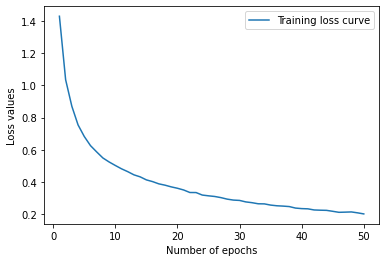

In [ ]:
x_axis = np.array(range(1, num_epochs+1))  #x축: step 갯수(반복 횟수)

plt.plot(x_axis, train_loss_arr_f) #training, validation loss curve 출력

plt.legend(('Training loss curve', 'Training loss curve (Adam)'))
plt.xlabel('Number of epochs')
plt.ylabel('Loss values')

Text(0, 0.5, 'Accuracy on testing dataset')

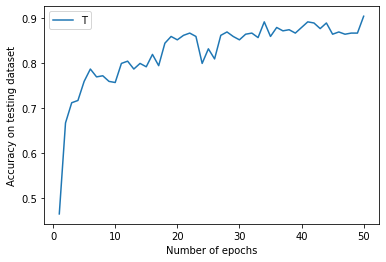

In [ ]:
x_axis = np.array(range(1, num_epochs+1))  #x축: step 갯수(반복 횟수)

plt.plot(x_axis, test_accuracy_arr_f) #training, validation loss curve 출력

plt.legend(('Testing accuracy curve (1-(f))'))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on testing dataset')